# Построение модели определения стоимости автомобиля

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжение предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings("ignore")

### Знакомство с данными

In [2]:
#открываем файл
try:
    data = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError: 
    data = pd.read_csv('datasets/autos.csv')

In [3]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


**Признаки** 

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак** 
* Price — цена (евро)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# сохраним изначальный размер таблицы
original_shape = data.shape[0]

In [6]:
# оцениваем пропуски
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
# процент пропусков
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

### Обработка пропусков, дубликатов, выбросов.

In [8]:
# число дубликатов
data.duplicated().sum()

4

In [9]:
data[data.duplicated(keep=False)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [10]:
# удаляем дубликаты
data = data.drop_duplicates()

In [11]:
data.duplicated().sum()

0

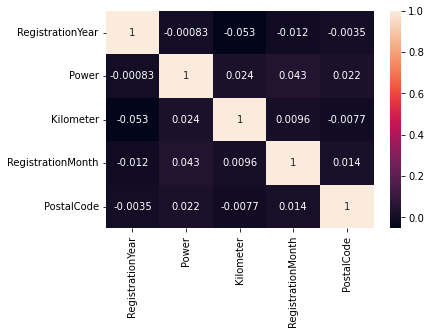

In [12]:
# оцениваем корреляцию
sns.heatmap(data.drop(['Price', 'NumberOfPictures'], axis=1).corr(), annot=True);

Сильно коррелирирующих между собой признаков нет, по этому принципу удалять признаки не требуется.

Теперь оценим количество различных значений признаков.

In [13]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [14]:
data['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [15]:
data['Gearbox'].value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

In [16]:
data['Model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [17]:
data['FuelType'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [18]:
data['NotRepaired'].value_counts()

no     247158
yes     36053
Name: NotRepaired, dtype: int64

In [19]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

#### Даты объявлений

Оценим год и месяц создания объявлений и загрузки анкет, возможно, сезон влияет на стоимость продаж.

In [20]:
data['DateCrawled_year'] = pd.to_datetime(data['DateCrawled']).dt.year

In [21]:
data['DateCrawled_year'].value_counts()

2016    354365
Name: DateCrawled_year, dtype: int64

In [22]:
data['DateCrawled_month'] = pd.to_datetime(data['DateCrawled']).dt.month

In [23]:
data['DateCrawled_month'].value_counts()

3    296821
4     57544
Name: DateCrawled_month, dtype: int64

In [24]:
data['DateCreated_year'] = pd.to_datetime(data['DateCreated']).dt.year

In [25]:
data['DateCreated_year'].value_counts()

2016    354339
2015        25
2014         1
Name: DateCreated_year, dtype: int64

In [26]:
data['DateCreated_month'] = pd.to_datetime(data['DateCreated']).dt.month

In [27]:
data['DateCreated_month'].value_counts()

3     296756
4      57118
2        397
1         70
11         9
12         9
9          3
8          2
6          1
Name: DateCreated_month, dtype: int64

Все анкеты созданы и загружены примерно в одно время, для обучения эти данные будут неинформативны, удалим столбцы с датами.

In [28]:
data['NumberOfPictures'].value_counts()

0    354365
Name: NumberOfPictures, dtype: int64

Во всех анкетах нет фото, можно удалить этот столбец. Так же удалим индекс и дату последней активности пользователя.

In [29]:
data = data.drop(['DateCrawled', 'DateCrawled_year','DateCrawled_month', 'DateCreated', 'DateCreated_year', 
                  'DateCreated_month', 'NumberOfPictures', 'LastSeen', 'PostalCode'], axis=1)

In [30]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


#### Пропуски по нескольким признакм

Оценим строки, в которых пропущено сразу несколько значений.

In [31]:
data[(data.VehicleType.isna() & (data.Gearbox.isna()) & (data.Model.isna()) & (data.Brand == 'sonstige_autos'))]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
306,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN
1345,899,NaN,1990,NaN,37,NaN,60000,2,NaN,sonstige_autos,NaN
1537,300,NaN,2010,NaN,0,NaN,150000,12,NaN,sonstige_autos,NaN
2065,0,NaN,2000,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN
2077,2250,NaN,2005,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN
...,...,...,...,...,...,...,...,...,...,...,...
353584,1,NaN,2000,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN
353961,200,NaN,1910,NaN,0,NaN,5000,0,petrol,sonstige_autos,NaN
354073,1750,NaN,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,NaN
354083,0,NaN,2000,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN


В этих данных только пробег и год выпуска: это не очень информативно для нашей модели, удалим данные. 

In [32]:
data = data.drop(data[(data.VehicleType.isna()) & (data.Gearbox.isna()) & (data.Model.isna()) & 
                      (data.Brand == 'sonstige_autos')].index)

#### Год регистрации автомобиля

Теперь рассмотрим числовые признаки, оценим их на выбросы.

In [33]:
data['RegistrationYear'].value_counts()

2000    24220
1999    22727
2005    22039
2001    20123
2006    19896
        ...  
1001        1
2200        1
1925        1
1919        1
1600        1
Name: RegistrationYear, Length: 141, dtype: int64

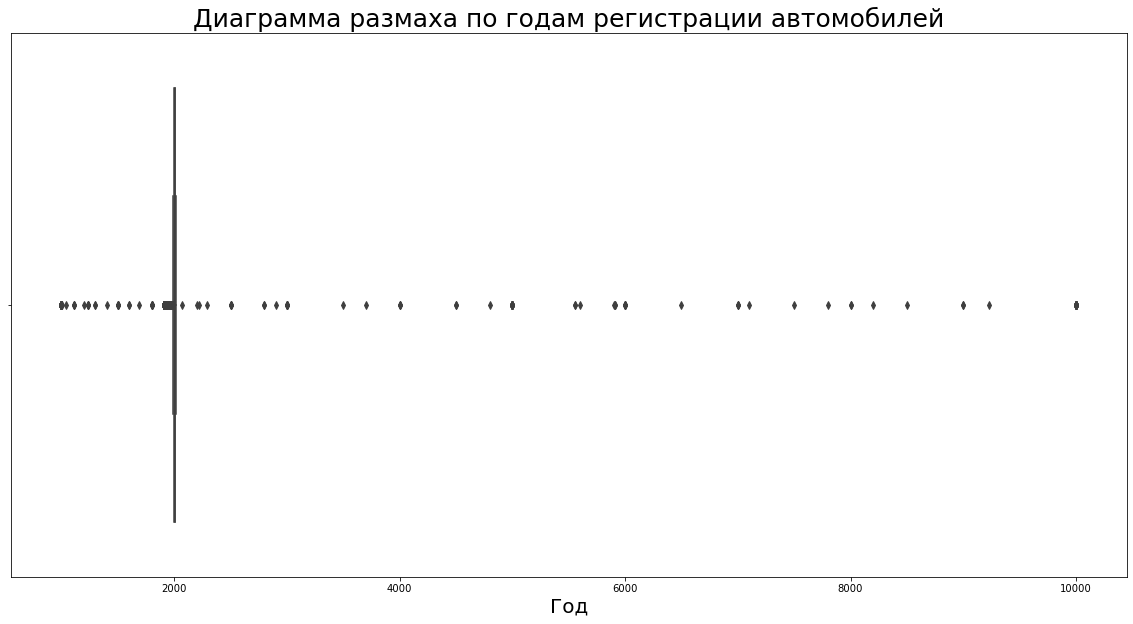

In [35]:
plt.figure(figsize=(20, 10))
sns.boxplot(data['RegistrationYear'])
plt.xlabel('Год', fontsize=20)
plt.title('Диаграмма размаха по годам регистрации автомобилей', fontsize=25);

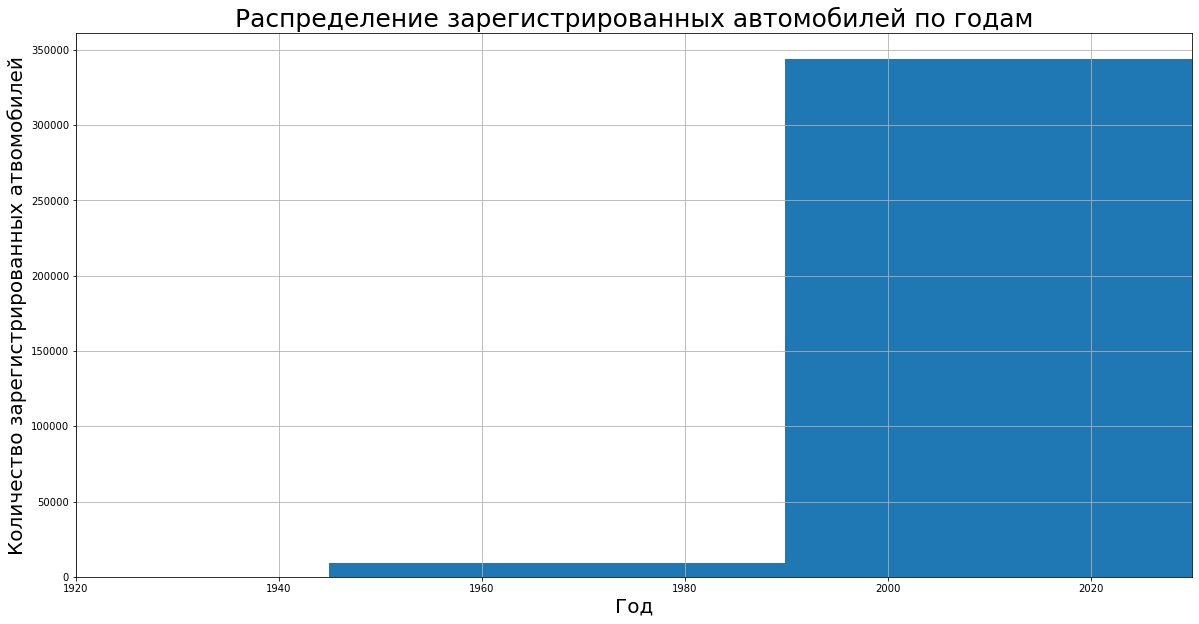

In [36]:
plt.figure(figsize=(20, 10))
plt.xlim([1920, 2030])
data['RegistrationYear'].hist(bins=200)
plt.xlabel('Год', fontsize=20)
plt.ylabel('Количество зарегистрированных атвомобилей', fontsize=20)
plt.title('Распределение зарегистрированных автомобилей по годам', fontsize=25);

In [37]:
data.query('2018 >= RegistrationYear > 2016')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no
48,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN
51,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes
57,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no
...,...,...,...,...,...,...,...,...,...,...,...
354112,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN
354140,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN
354203,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no
354253,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN


Примерно 14400 строк с данными 2017-2018гг, но анкеты у нас загружены в 2016г. Это около 4% данных, можно их удалить.

In [38]:
data.query('RegistrationYear > 2018')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
12946,49,NaN,5000,NaN,0,golf,5000,12,NaN,volkswagen,NaN
17271,700,NaN,9999,NaN,0,other,10000,0,NaN,opel,NaN
18259,300,NaN,2200,NaN,0,twingo,5000,12,NaN,renault,NaN
26382,150,NaN,3000,NaN,0,a_klasse,5000,0,NaN,mercedes_benz,NaN
26560,800,NaN,2066,NaN,0,zafira,5000,0,gasoline,opel,NaN
...,...,...,...,...,...,...,...,...,...,...,...
334967,12000,NaN,4000,NaN,500,golf,5000,0,NaN,volkswagen,no
335727,0,NaN,7500,manual,0,other,10000,0,petrol,mini,no
338829,50,NaN,3000,NaN,3000,golf,100000,6,NaN,volkswagen,yes
340548,0,NaN,3500,manual,75,NaN,5000,3,petrol,sonstige_autos,NaN


Отбросим так же автомобили старше 80 лет. 

In [39]:
data.query('RegistrationYear < 1935')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN
622,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN
2273,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no
6629,0,small,1910,NaN,0,NaN,5000,1,other,sonstige_autos,NaN
6977,135,NaN,1910,NaN,0,NaN,5000,0,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...,...
334901,1300,NaN,1910,NaN,0,NaN,5000,9,NaN,audi,NaN
336104,20000,coupe,1929,manual,12,other,10000,4,petrol,bmw,NaN
340759,700,NaN,1600,manual,1600,a3,150000,4,petrol,audi,no
343083,1,other,1910,NaN,0,NaN,5000,1,other,volkswagen,NaN


In [40]:
data = data.query('1935 < RegistrationYear <= 2016')

In [41]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [42]:
data.query('RegistrationYear < 1935')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired


In [43]:
data.query('RegistrationYear > 2016')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired


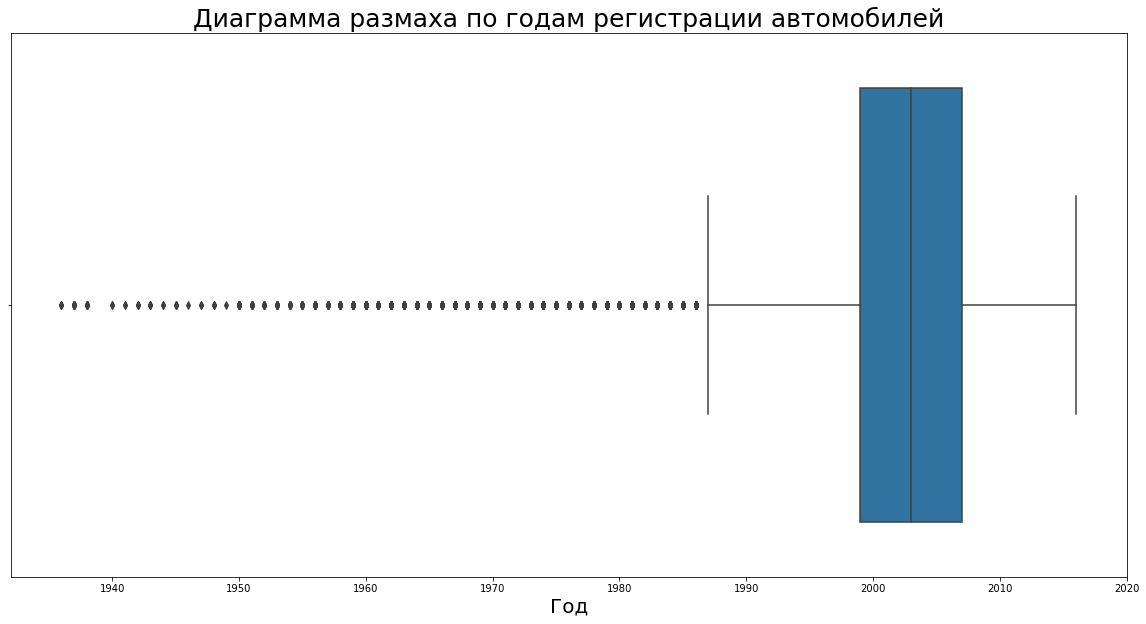

In [44]:
plt.figure(figsize=(20, 10))
sns.boxplot(data['RegistrationYear'])
plt.xlabel('Год', fontsize=20)
plt.title('Диаграмма размаха по годам регистрации автомобилей', fontsize=25);

#### Мощность автомобиля

Оценим мощность автомобилей.

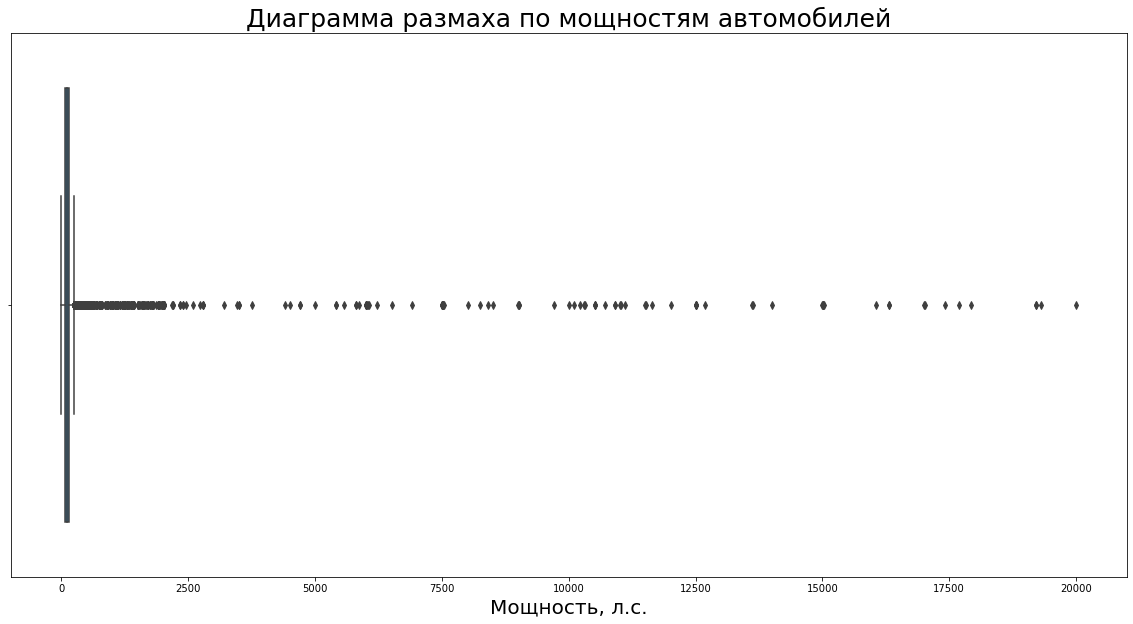

In [46]:
plt.figure(figsize=(20, 10))
sns.boxplot(data['Power'])
plt.xlabel('Мощность, л.с.', fontsize=20)
plt.title('Диаграмма размаха по мощностям автомобилей', fontsize=25);

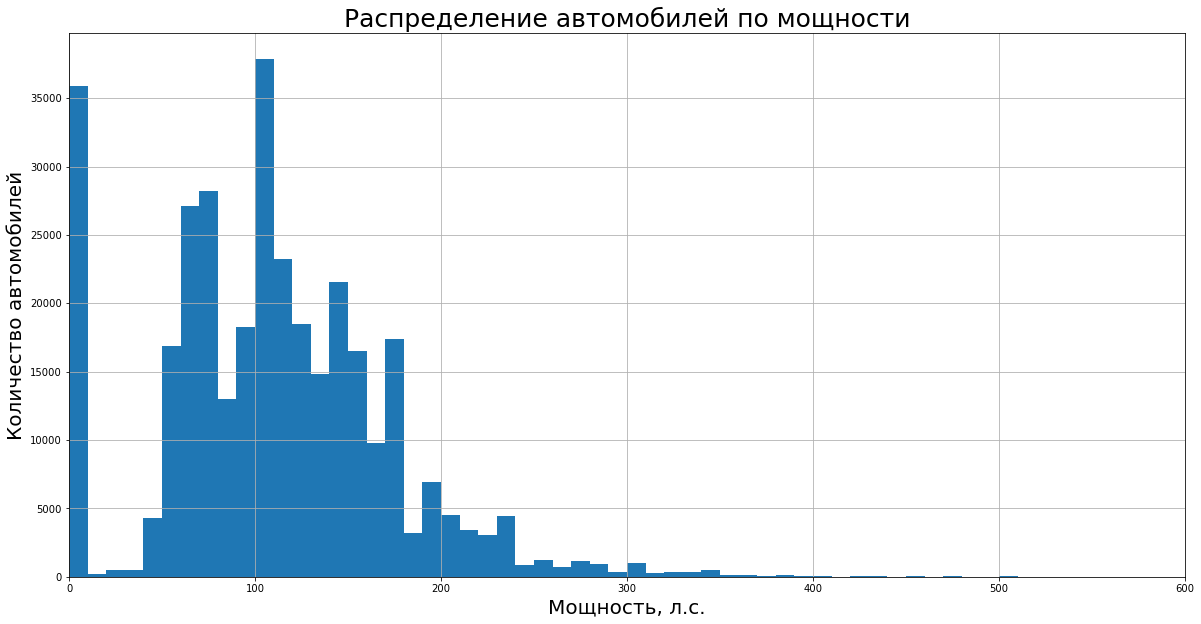

In [47]:
plt.figure(figsize=(20, 10))
plt.xlim([0,600])
plt.xlabel('Мощность, л.с.', fontsize=20)
plt.ylabel('Количество автомобилей', fontsize=20)
plt.title('Распределение автомобилей по мощности', fontsize=25);
data['Power'].hist(bins=2000);

На графиках видно большое количество выбросов по мощности автомобилей. Удалим сначала автомобили со слишком большой мощностью. Более 35000 значений около 0. Вероятно, авторы объявлений просто не указали данные, либо указали с ошибкой. Самые маломощные автомобили имеют двигатели 4, 13 и 19 л.с. Проверим, нет ли у нас таких моделей.

In [48]:
data.query("Model == 'isetta' or Model == 'midget' or Model == '2cv' or Model == 'p50' or Model =='qute'")

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired


In [49]:
data['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Моделей с такой мощностью в данных нет, поэтому все, что меньше 19 л.с. будем считать выбросами и заменим. 

Дешевые авто с большой мощностью тоже будем считать выбросами.

In [50]:
data.query('Power > 500 and Price < 12000' )

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1816,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no
2102,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes
4060,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN
6296,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes
...,...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,NaN
348968,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no
353633,2400,sedan,2007,manual,650,c2,150000,8,petrol,citroen,NaN


In [51]:
data.query('Power > 500' )

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1816,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no
2102,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes
4060,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN
6296,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes
...,...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,NaN
348968,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no
353633,2400,sedan,2007,manual,650,c2,150000,8,petrol,citroen,NaN


In [52]:
data.query('1000 > Power > 500 and Price > 12000' )

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
13373,18500,small,2002,auto,600,s_type,150000,12,NaN,jaguar,no
17510,15500,coupe,2009,auto,507,m_reihe,150000,1,petrol,bmw,yes
20145,18500,suv,2006,auto,521,cayenne,150000,5,petrol,porsche,no
25684,20000,sedan,2006,auto,507,m_reihe,150000,6,petrol,bmw,no
32693,16999,sedan,2006,auto,515,a8,150000,6,petrol,audi,no
43600,12999,wagon,2004,auto,600,a6,150000,2,petrol,audi,NaN
46941,15000,coupe,2013,auto,751,NaN,10000,1,petrol,sonstige_autos,no
73749,18500,sedan,2012,auto,520,other,50000,0,petrol,audi,yes
75230,17999,sedan,2012,auto,560,m_reihe,40000,7,petrol,bmw,no
82421,13500,suv,2006,auto,521,cayenne,150000,5,NaN,porsche,yes


In [53]:
data = data.drop(data[(data.Power > 500) & (data.Price < 12000)].index)

In [54]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [55]:
data.query('Power > 500 and Price < 12000' )

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired


In [56]:
data.query('Power < 19')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no
40,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN
54,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no
...,...,...,...,...,...,...,...,...,...,...,...
354338,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN
354346,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN
354360,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no


In [57]:
data.query('Power < 19').Power.value_counts()

0     35676
5       103
18       50
4        30
1        30
11       27
14       19
12       19
15       17
10       12
7        11
6        11
2        10
3         8
16        7
17        7
13        6
9         5
8         5
Name: Power, dtype: int64

In [58]:
# заменим все значения меньше 19 на NaN, а затем на медиану по бренду.
data.loc[data['Power'] < 19, 'Power'] = np.nan
data['Power'] = data['Power'].fillna(data.groupby('Brand')['Power'].transform('median')) 

In [59]:
data.query('Power < 19').Power.value_counts()

Series([], Name: Power, dtype: int64)

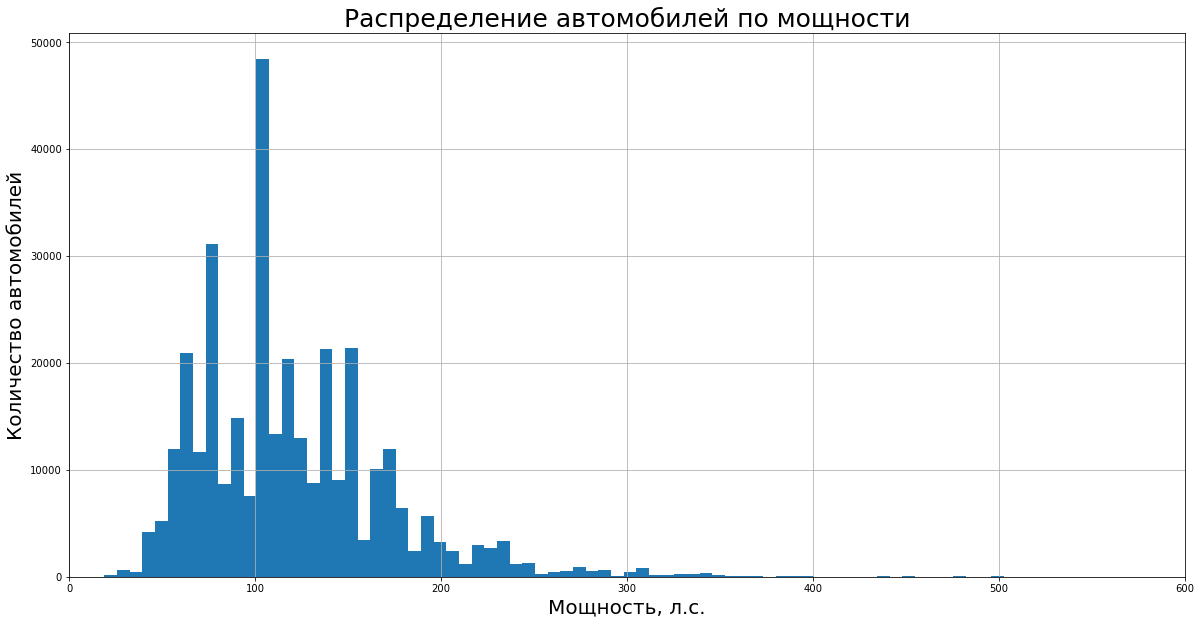

In [60]:
plt.figure(figsize=(20, 10))
plt.xlim([0,600])
plt.xlabel('Мощность, л.с.', fontsize=20)
plt.ylabel('Количество автомобилей', fontsize=20)
plt.title('Распределение автомобилей по мощности', fontsize=25);
data['Power'].hist(bins=2000);

In [61]:
data.isna().sum()

Price                    0
VehicleType          22110
RegistrationYear         0
Gearbox              17106
Power                    0
Model                16811
Kilometer                0
RegistrationMonth        0
FuelType             26457
Brand                    0
NotRepaired          63912
dtype: int64

#### Пропуски в категориальных данных

In [62]:
# остальные пропуски заменим на значение "не указано"
data = data.fillna('not specified')

In [63]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,not specified,1993,manual,101.0,golf,150000,0,petrol,volkswagen,not specified
1,18300,coupe,2011,manual,190.0,not specified,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,not specified
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,101.0,zafira,150000,3,petrol,opel,no
354364,0,not specified,2005,manual,113.0,colt,150000,7,petrol,mitsubishi,yes
354366,1199,convertible,2000,auto,101.0,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102.0,transporter,150000,3,gasoline,volkswagen,no


In [64]:
data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

#### Пробег

Оцениваем данные по пробегу.

In [65]:
data['Kilometer'].value_counts()

150000    227057
125000     35002
100000     14321
90000      11185
80000       9744
70000       8350
60000       7269
50000       6054
5000        5585
40000       4810
30000       4298
20000       3792
10000       1109
Name: Kilometer, dtype: int64

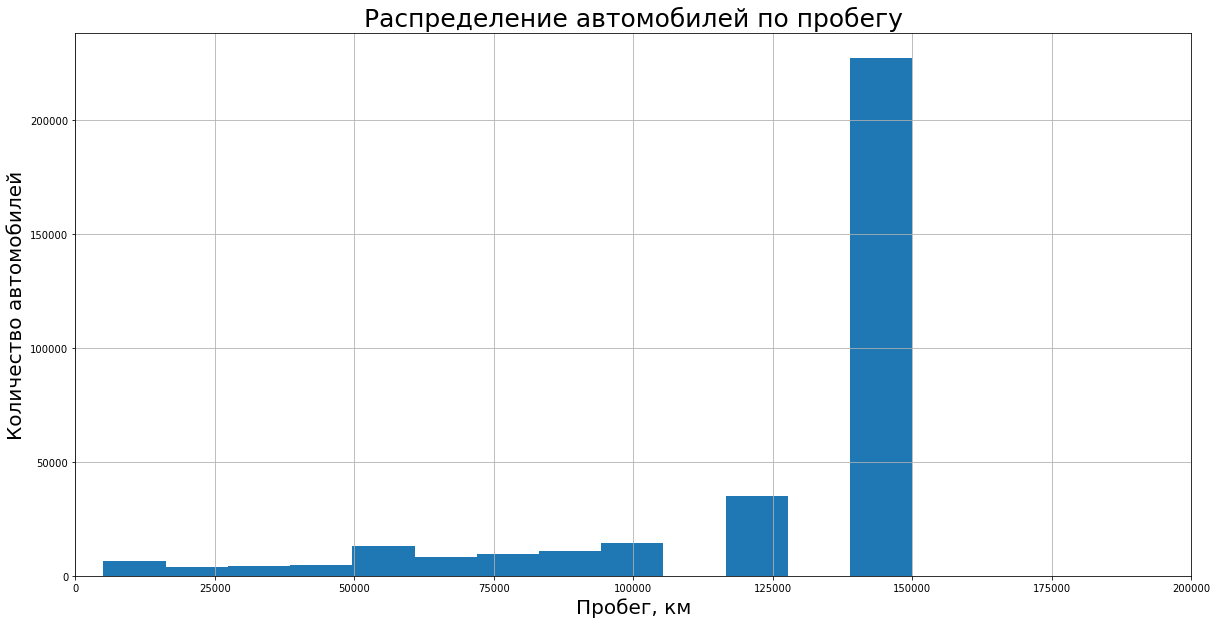

In [66]:
plt.figure(figsize=(20, 10))
plt.xlim([0,200000])
plt.xlabel('Пробег, км', fontsize=20)
plt.ylabel('Количество автомобилей', fontsize=20)
plt.title('Распределение автомобилей по пробегу', fontsize=25);
data['Kilometer'].hist(bins=13);

По пробегу данные выглядят адекватно.

#### Стоимость

Оценим данные по стоимости.

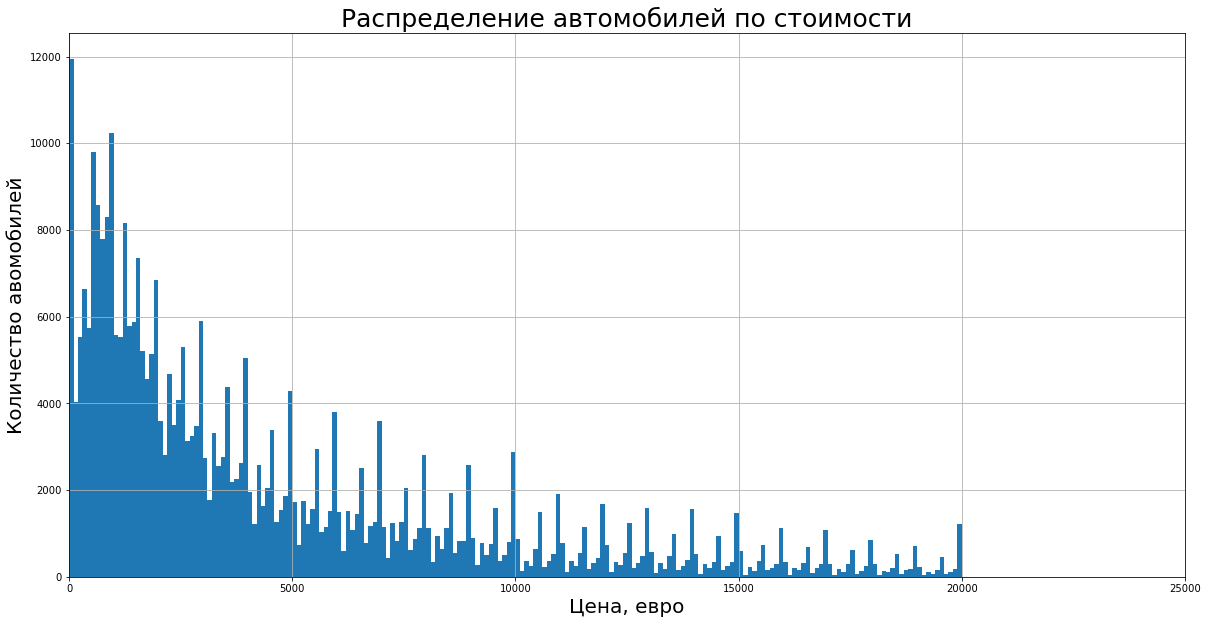

In [67]:
plt.figure(figsize=(20, 10))
plt.xlim([0,25000])
plt.xlabel('Цена, евро', fontsize=20)
plt.ylabel('Количество авомобилей', fontsize=20)
plt.title('Распределение автомобилей по стоимости', fontsize=25);
data['Price'].hist(bins=200);

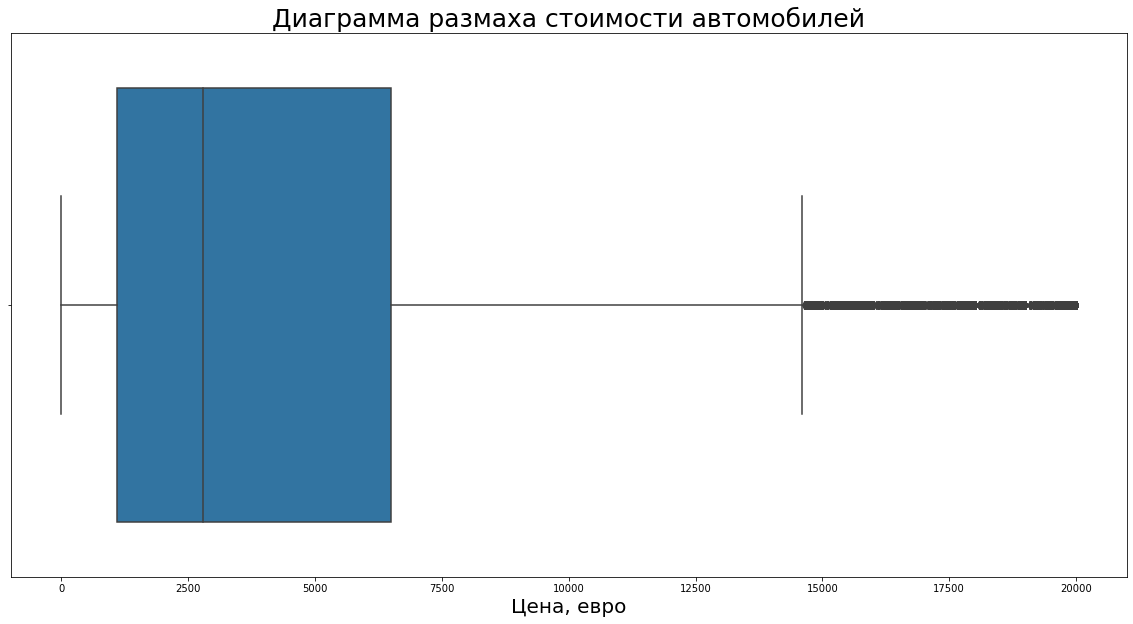

In [68]:
plt.figure(figsize=(20, 10))
sns.boxplot(data['Price'])
plt.xlabel('Цена, евро', fontsize=20)
plt.title('Диаграмма размаха стоимости автомобилей', fontsize=25);

In [69]:
data.query('Price > 15000')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190.0,not specified,125000,5,gasoline,audi,yes
14,17999,suv,2011,manual,190.0,navara,70000,3,gasoline,nissan,no
33,18000,sedan,2007,auto,218.0,3er,20000,5,petrol,bmw,no
172,19750,convertible,2006,manual,305.0,mustang,50000,7,petrol,ford,no
179,16449,wagon,2015,auto,110.0,fabia,10000,8,petrol,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354210,17990,bus,2007,auto,174.0,transporter,125000,7,gasoline,volkswagen,no
354279,16500,suv,2013,manual,116.0,i_reihe,30000,9,gasoline,hyundai,no
354286,16500,coupe,1973,manual,200.0,other,150000,6,petrol,bmw,yes
354306,16999,wagon,2008,auto,269.0,a6,150000,7,gasoline,audi,no


In [70]:
data.query('Price < 1000')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,not specified,1993,manual,101.0,golf,150000,0,petrol,volkswagen,not specified
5,650,sedan,1995,manual,102.0,3er,150000,10,petrol,bmw,yes
7,0,sedan,1980,manual,50.0,other,40000,7,petrol,volkswagen,no
9,999,small,1998,manual,101.0,golf,150000,0,not specified,volkswagen,not specified
12,999,wagon,1995,manual,115.0,passat,150000,11,petrol,volkswagen,not specified
...,...,...,...,...,...,...,...,...,...,...,...
354341,699,sedan,1999,manual,101.0,vectra,150000,3,petrol,opel,not specified
354342,600,small,1998,manual,54.0,corsa,150000,1,petrol,opel,no
354347,800,wagon,2000,manual,101.0,astra,150000,11,petrol,opel,yes
354356,999,convertible,2000,manual,95.0,megane,150000,4,petrol,renault,not specified


In [71]:
data.query('Price == 0')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50.0,other,40000,7,petrol,volkswagen,no
40,0,not specified,1990,not specified,101.0,corsa,150000,1,petrol,opel,not specified
115,0,small,1999,not specified,101.0,not specified,5000,0,petrol,volkswagen,not specified
152,0,bus,2004,manual,101.0,meriva,150000,10,lpg,opel,yes
154,0,not specified,2006,not specified,69.0,other,5000,0,not specified,fiat,not specified
...,...,...,...,...,...,...,...,...,...,...,...
354205,0,not specified,2000,manual,65.0,corsa,150000,0,not specified,opel,yes
354238,0,small,2002,manual,60.0,fiesta,150000,3,petrol,ford,not specified
354248,0,small,1999,manual,53.0,swift,150000,3,petrol,suzuki,not specified
354277,0,small,1999,manual,37.0,arosa,150000,7,petrol,seat,yes


In [72]:
data.query('Price < 100 and Price >0')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
59,1,suv,1994,manual,286.0,not specified,150000,11,not specified,sonstige_autos,not specified
89,1,sedan,1995,manual,113.0,e_klasse,150000,4,gasoline,mercedes_benz,no
268,1,sedan,1990,manual,90.0,80,70000,6,petrol,audi,no
408,1,not specified,2000,not specified,75.0,golf,90000,3,petrol,volkswagen,not specified
552,50,not specified,1985,not specified,26.0,not specified,150000,11,not specified,trabant,not specified
...,...,...,...,...,...,...,...,...,...,...,...
353673,90,small,1998,manual,60.0,other,150000,8,petrol,citroen,yes
353682,1,bus,1999,manual,76.0,espace,150000,0,petrol,renault,not specified
353727,1,not specified,2000,not specified,163.0,not specified,150000,0,not specified,bmw,not specified
354117,1,wagon,1993,auto,217.0,5er,150000,12,petrol,bmw,not specified


Около 9600 объявлений со стоимостью 0 и еще 2300 менее 100 евро. Возможно, владельцы просто хотят отдать даром свой автомобиль или ошиблись со стоимостью, или это объявления, снятые до продажи. Но нам требуется модель для  разработки приложения, в котором можно быстро узнать рыночную стоимость своего автомобиля. Поэтому бесплатные машины для этой задачи не актуальны, эти данные удалим. 

In [73]:
data = data.query('Price > 100')

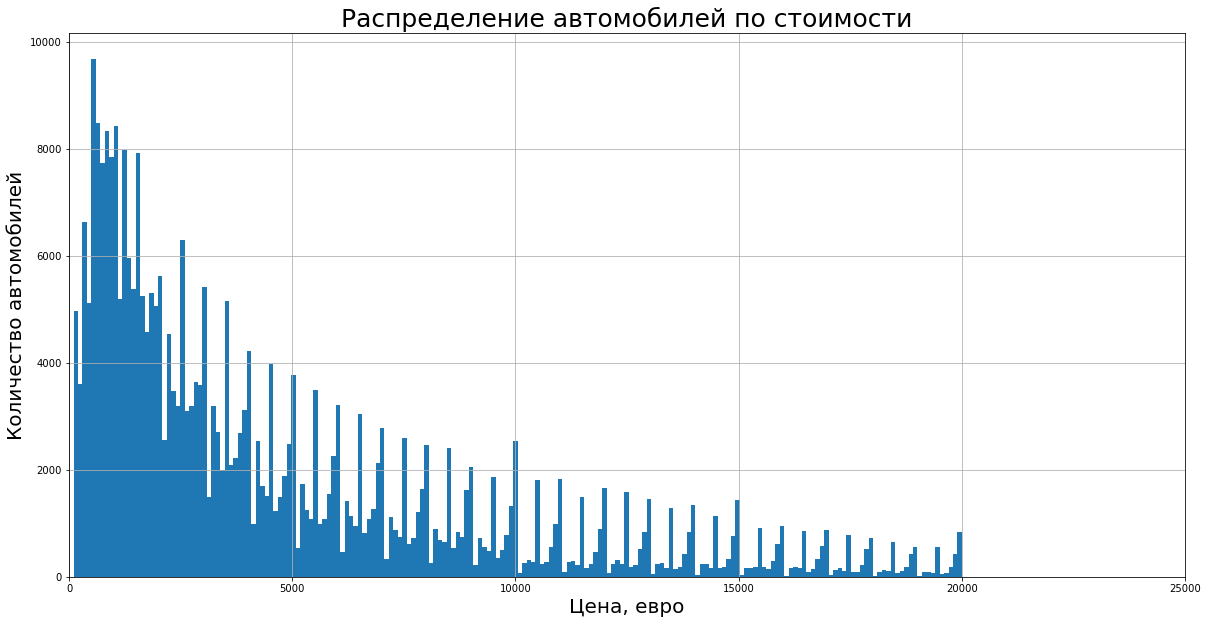

In [74]:
plt.figure(figsize=(20, 10))
plt.xlim([0,25000])
plt.xlabel('Цена, евро', fontsize=20)
plt.ylabel('Количество автомобилей', fontsize=20)
plt.title('Распределение автомобилей по стоимости', fontsize=25);
data['Price'].hist(bins=200);

Пропуски и аномалии в данных обработаны, данные готовы для дальнейшей работы.

In [75]:
print("Удалено {:.3%} данных.".format((1 - data.shape[0] / original_shape)))

Удалено 8.109% данных.


## Обучение моделей

Кодируем категориальные признаки.

In [74]:
data.select_dtypes(include='object').columns

Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], dtype='object')

In [75]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [76]:
data_ohe

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_not specified,VehicleType_other,VehicleType_sedan,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_not specified,NotRepaired_yes
0,480,1993,101.0,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190.0,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.0,150000,6,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69.0,90000,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,2004,225.0,150000,5,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
354363,1150,2000,101.0,150000,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354366,1199,2000,101.0,125000,3,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354367,9200,1996,102.0,150000,3,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [77]:
# Разделяем данные на выборки
features_train, features_test, target_train, target_test = train_test_split(
    data_ohe.drop('Price', axis=1), data_ohe.Price, test_size=0.25, random_state=12345) 
print('Размеры обучающей выборки:', features_train.shape, target_train.shape)
print('Размеры тестовой выборки:', features_test.shape, target_test.shape)

Размеры обучающей выборки: (244224, 312) (244224,)
Размеры тестовой выборки: (81409, 312) (81409,)


### Линейная регрессия

In [78]:
%%time

linreg = LinearRegression()
mse = abs(cross_val_score(linreg, features_train, target_train,  scoring='neg_mean_squared_error', cv=10).mean())

print("Linear Regression")
print("MSE =", mse)
print("RMSE =", mse ** 0.5)
print()

Linear Regression
MSE = 7864637.044909557
RMSE = 2804.396021411662

Wall time: 38.9 s


In [87]:
%%time

linreg = LinearRegression()
mse = abs(cross_val_score(linreg, features_train_forest, target_train_forest,  scoring='neg_mean_squared_error', cv=10).mean())

print("Linear Regression")
print("MSE =", mse)
print("RMSE =", mse ** 0.5)
print()

Linear Regression
MSE = 10294006.574002456
RMSE = 3208.4274300663956

Wall time: 798 ms


Метрика RMSE превышает требуемую 2500. Попробуем масштабировать признаки. 

In [358]:
%%time
scaler = StandardScaler()
scaler.fit(features_train) 
features_train_scaled = scaler.transform(features_train)

linreg = LinearRegression()
mse = abs(cross_val_score(linreg, features_train_scaled, target_train,  scoring='neg_mean_squared_error', cv=10).mean())

print("Linear Regression, масштабированная")

print("MSE =", mse)
print("RMSE =", mse ** 0.5)
print()


Linear Regression, масштабированная
MSE = 18145755.795573812
RMSE = 4259.783538581956

Wall time: 47.8 s


После масштабирования метрика ухудшилась. Попробуем другие модели. 

### Дерево решений

In [359]:
grid_tree = { 
        'max_depth': range (1, 15, 1),
    
}

gd_sr_tree = GridSearchCV(DecisionTreeRegressor(), 
                     param_grid=grid_tree,
                     n_jobs=-1,
                     cv=5,
                     scoring='neg_mean_squared_error',
                     verbose=3)

In [360]:
%%time
gd_sr_tree.fit(features_train, target_train)
print('Лучшее значение глубины:', gd_sr_tree.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Лучшее значение глубины: {'max_depth': 14}
Wall time: 1min 48s


In [361]:
print("RMSE =", abs(gd_sr_tree.best_score_) ** 0.5)

RMSE = 1909.5099050648848


### Случайный лес

In [79]:
data.select_dtypes(include='object').columns

Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], dtype='object')

In [80]:
# Кодируем признаки с помощью OrdinalEncoder
enc = OrdinalEncoder()
data[['VehicleType', 'Gearbox', 'Model', 'FuelType','Brand', 'NotRepaired', 'RegistrationMonth']] = enc.fit_transform(data[[
    'VehicleType', 'Gearbox', 'Model', 'FuelType','Brand', 'NotRepaired', 'RegistrationMonth']])

In [81]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,3.0,1993,1.0,101.0,116.0,150000,0.0,7.0,38.0,1.0
1,18300,2.0,2011,1.0,190.0,161.0,125000,5.0,2.0,1.0,2.0
2,9800,7.0,2004,0.0,163.0,117.0,125000,8.0,2.0,14.0,1.0
3,1500,6.0,2001,1.0,75.0,116.0,150000,6.0,7.0,38.0,0.0
4,3600,6.0,2008,1.0,69.0,101.0,90000,7.0,2.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,5.0,2004,1.0,225.0,140.0,150000,5.0,7.0,30.0,2.0
354363,1150,0.0,2000,1.0,101.0,250.0,150000,3.0,7.0,24.0,0.0
354366,1199,1.0,2000,0.0,101.0,106.0,125000,3.0,7.0,32.0,0.0
354367,9200,0.0,1996,1.0,102.0,225.0,150000,3.0,2.0,38.0,0.0


In [82]:
data.dtypes

Price                  int64
VehicleType          float64
RegistrationYear       int64
Gearbox              float64
Power                float64
Model                float64
Kilometer              int64
RegistrationMonth    float64
FuelType             float64
Brand                float64
NotRepaired          float64
dtype: object

In [83]:
data[['VehicleType', 'Gearbox', 'Model', 'FuelType','Brand', 'NotRepaired', 'RegistrationMonth']] =data[[
    'VehicleType', 'Gearbox', 'Model', 'FuelType','Brand', 'NotRepaired', 'RegistrationMonth']].astype('category')

In [84]:
data.dtypes

Price                   int64
VehicleType          category
RegistrationYear        int64
Gearbox              category
Power                 float64
Model                category
Kilometer               int64
RegistrationMonth    category
FuelType             category
Brand                category
NotRepaired          category
dtype: object

In [86]:
# Делим преобразованные данные на выборки
features_train_forest, features_test_forest, target_train_forest, target_test_forest = train_test_split(
    data.drop('Price', axis=1), data.Price, test_size=0.25, random_state=12345) 
print('Размеры обучающей выборки:', features_train_forest.shape, target_train_forest.shape)
print('Размеры тестовой выборки:', features_test_forest.shape, target_test_forest.shape)

Размеры обучающей выборки: (244224, 10) (244224,)
Размеры тестовой выборки: (81409, 10) (81409,)


In [368]:
# Подбираем гиперпараметры методом GridSearchCV
grid_1 = { 
    'n_estimators': range (10, 20, 5),
    'max_depth': range (1,4, 1),
    
}

gd_sr_forest_1 = GridSearchCV(RandomForestRegressor(), 
                     param_grid=grid_1,
                     n_jobs=-1,
                     cv=5,
                     scoring='neg_mean_squared_error',
                     verbose=3)

In [369]:
%%time
gd_sr_forest_1.fit(features_train_forest, target_train_forest)
print(gd_sr_forest_1.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'max_depth': 3, 'n_estimators': 15}
Wall time: 15.5 s


In [370]:
print("RMSE =", abs(gd_sr_forest_1.best_score_) ** 0.5)

RMSE = 2921.0734600923715


In [377]:
grid_2 = { 
    'n_estimators': range (20, 250, 40),
    'max_depth': range (3,15, 2),
    
}

gd_sr_forest_2 = GridSearchCV(RandomForestRegressor(), 
                     param_grid=grid_2,
                     n_jobs=-1,
                     cv=5,
                     scoring='neg_mean_squared_error',
                     verbose=3)


In [378]:
%%time
gd_sr_forest_2.fit(features_train_forest, target_train_forest)
print(gd_sr_forest_2.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'max_depth': 13, 'n_estimators': 220}
Wall time: 37min 1s


In [379]:
print("Случайный лес при лучших параметрах,  RMSE =", abs(gd_sr_forest_2.best_score_) ** 0.5)

Случайный лес при лучших параметрах,  RMSE = 1726.196456648158


### LightGBM

In [374]:
%%time
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.02, 0.1, 0.2, 0.5, 1],
    'n_estimators': range (20, 200, 50),
}

gbm = GridSearchCV(estimator, param_grid, scoring='neg_mean_squared_error', cv=5)
gbm.fit(features_train, target_train)

print('Лучшие параметры:', gbm.best_params_)

Лучшие параметры: {'learning_rate': 0.5, 'n_estimators': 170}
Wall time: 3min 46s


In [376]:
print("RMSE =", abs(gbm.best_score_) ** 0.5)

RMSE = 1608.7169494672098


In [380]:
%%time
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.02, 0.1, 0.2, 0.5, 1],
    'n_estimators': range (20, 200, 50),
}

gbm_2 = GridSearchCV(estimator, param_grid, scoring='neg_mean_squared_error', cv=5)
gbm_2.fit(features_train_forest, target_train_forest)

print('Лучшие параметры:', gbm_2.best_params_)

Лучшие параметры: {'learning_rate': 0.2, 'n_estimators': 170}
Wall time: 1min 23s


In [381]:
print("RMSE =", abs(gbm_2.best_score_) ** 0.5)

RMSE = 1591.1263177365734


In [ ]:
Наилучший результат показала модель LightGBM.

## Анализ моделей

In [391]:
print("Дерево решений, max_depth=14, RMSE =", abs(gd_sr_tree.best_score_) ** 0.5)
print("Случайный лес, max_depth=13, n_estimators=220, RMSE =", abs(gd_sr_forest_2.best_score_) ** 0.5)
print("LightGBM, learning_rate=0.2, n_estimators=170, RMSE =", abs(gbm_2.best_score_) ** 0.5)

Дерево решений, max_depth=14, RMSE = 1909.5099050648848
Случайный лес, max_depth=13, n_estimators=220, RMSE = 1726.196456648158
LightGBM, learning_rate=0.2, n_estimators=170, RMSE = 1591.1263177365734


3 модели показали результат в пределах заданной нормы 2500. Наилучшее значение у LightGBM.
Оценим время обучения и предсказания каждой модели.

### Дерево решений

In [382]:
%%time
tree = DecisionTreeRegressor(max_depth=14, random_state=12345)
tree.fit(features_train, target_train)

Wall time: 7.35 s


DecisionTreeRegressor(max_depth=14, random_state=12345)

In [395]:
%%time
mse = mean_squared_error(target_train, tree.predict(features_train))
print("RMSE, дерево решений", mse ** 0.5)

RMSE, дерево решений 1593.9326763785286
Wall time: 469 ms


### Случайный лес

In [386]:
%%time
forest = RandomForestRegressor(max_depth=13,n_estimators=220, random_state=12345)
forest.fit(features_train_forest, target_train_forest)

Wall time: 1min 55s


RandomForestRegressor(max_depth=13, n_estimators=220, random_state=12345)

In [387]:
%%time
mse = mean_squared_error(target_train, forest.predict(features_train_forest))
print("RMSE, случайный лес", mse ** 0.5)

RMSE, случайный лес 1499.8948263921304
Wall time: 8.09 s


### LightGBM

In [388]:
%%time
gbm = lgb.LGBMRegressor(num_leaves=31,learning_rate=0.2,n_estimators=170)
gbm.fit(features_train_forest, target_train_forest)

Wall time: 914 ms


LGBMRegressor(learning_rate=0.2, n_estimators=170)

In [394]:
%%time
mse = mean_squared_error(target_train_forest, gbm.predict(features_train_forest))
print("RMSE, LightGBM", mse ** 0.5)

RMSE, LightGBM 1468.8086277572756
Wall time: 828 ms


In [90]:
%%time
gbm = lgb.LGBMRegressor(num_leaves=31,learning_rate=0.2,n_estimators=1000)
gbm.fit(features_train, target_train)
mse = mean_squared_error(target_test, gbm.predict(features_test))
print("RMSE, LightGBM", mse ** 0.5)

RMSE, LightGBM 1531.7934072162802
Wall time: 5.83 s


* Самое быстрое время обучения у *LightGBM*: **914 ms**, у *дерева решений* - **7.35 s**. 
* Самое быстрое время предсказания у *дерева решений* : **469 ms** , у *LightGBM* примерно в 2 раза дольше: **828 ms**.
* У *случайного леса* самое большое время обучения (**1min 55**) и время предсказания составило **8.09 s**.

У всех моделей метрики в пределах установленной нормы 2500. 
Наилучшие результаты по метрике показала модель LightGBM, так же у нее высокая скорость обучения и предсказания. 
Проверим ее на тестовой выборке.

In [396]:
%%time
mse = mean_squared_error(target_test_forest, gbm.predict(features_test_forest))
print("LightGBM, Тестовая выборка, RMSE = ", mse ** 0.5)

LightGBM, Тестовая выборка, RMSE =  1573.8913415565883
Wall time: 629 ms


Метрика в пределах заданной, скорость предсказания высокая.
Сервису по продаже автомобилей с пробегом «Не бит, не крашен» для разрабатываемого приложения с функцией оценки рыночной стоимости своего автомобиля рекомендуется использовать модель LightGBM.